## 1.0 Setup
Import modules


In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier 
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC

np.random.seed(1)

## 2.0 Load data
Load data (it's already cleaned and preprocessed)


In [2]:
X_train = pd.read_csv('./airbnb_train_X_price_gte_150.csv') 
y_train = pd.read_csv('./airbnb_train_y_price_gte_150.csv') 
X_test = pd.read_csv('./airbnb_test_X_price_gte_150.csv') 
y_test = pd.read_csv('./airbnb_test_y_price_gte_150.csv') 

## NOTE: In this next section, GridSearch will use K Fold Cross Validation 

K-Fold cross validation is used to avoid overfitting. 

In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data. The k results can then be averaged to produce a single estimation. 

![cross validation diagram](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)


## 3.0 Model the data

## Decision Tree with Randomized Search Approach

In [5]:
score_measure = "precision"
kfolds = 5

param_grid = {
    'min_samples_split': np.arange(1,70),  
    'min_samples_leaf': np.arange(1,70),
    'min_impurity_decrease': np.arange(0.0001, 0.01, 0.0005),
    'max_leaf_nodes': np.arange(5, 100), 
    'max_depth': np.arange(1,20), 
    'criterion': ['entropy', 'gini'],
}

dtree = DecisionTreeClassifier()
rand_search = RandomizedSearchCV(estimator = dtree, param_distributions=param_grid, cv=kfolds, n_iter=100,
                           scoring=score_measure, verbose=1, n_jobs=-1,  # n_jobs=-1 will utilize all available CPUs 
                           return_train_score=True)

_ = rand_search.fit(X_train, y_train)

print(f"The best {score_measure} score is {rand_search.best_score_}")
print(f"... with parameters: {rand_search.best_params_}")

bestPrecisionTree = rand_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
The best precision score is 0.8570034316615264
... with parameters: {'min_samples_split': 37, 'min_samples_leaf': 19, 'min_impurity_decrease': 0.0021, 'max_leaf_nodes': 58, 'max_depth': 18, 'criterion': 'gini'}


In [9]:
c_matrix = confusion_matrix(y_test, rand_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
print(f"Accuracy={(TP+TN)/(TP+TN+FP+FN):.7f} Precision={TP/(TP+FP):.7f} Recall={TP/(TP+FN):.7f} F1={2*TP/(2*TP+FP+FN):.7f}")

Accuracy=0.8472352 Precision=0.8333333 Recall=0.8662900 F1=0.8494922


## SVM using polynomial kernel with Randomized Search Approach

In [12]:
score_measure = "precision"
kfolds = 5

param_rand = {
    'C': np.arange(5,15),
    'degree': [3,4,5],
    'gamma': ['scale', 'auto'],
    'coef0': np.arange(1,7)
}

svm_poly_model = SVC(kernel="poly")
random_search = RandomizedSearchCV(estimator = svm_poly_model, param_distributions=param_rand, cv=kfolds, n_iter=50,
                           scoring=score_measure, verbose=1, n_jobs=-1,
                           return_train_score=True)

_ = random_search.fit(X_train,np.ravel(y_train))

print(f"The best {score_measure} score is {random_search.best_score_}")
print(f"... with parameters: {random_search.best_params_}")

bestSVM = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
The best precision score is 0.8537881498209234
... with parameters: {'gamma': 'auto', 'degree': 3, 'coef0': 2, 'C': 9}


In [10]:
c_matrix = confusion_matrix(y_test, random_search.predict(X_test))
TP = c_matrix[1][1]
TN = c_matrix[0][0]
FP = c_matrix[0][1]
FN = c_matrix[1][0]
print(f"Accuracy={(TP+TN)/(TP+TN+FP+FN):.7f} Precision={TP/(TP+FP):.7f} Recall={TP/(TP+FN):.7f} F1={2*TP/(2*TP+FP+FN):.7f}")

Accuracy=0.8594189 Precision=0.8482633 Recall=0.8738230 F1=0.8608534


##  4.0 Diagram of  Decision Tree

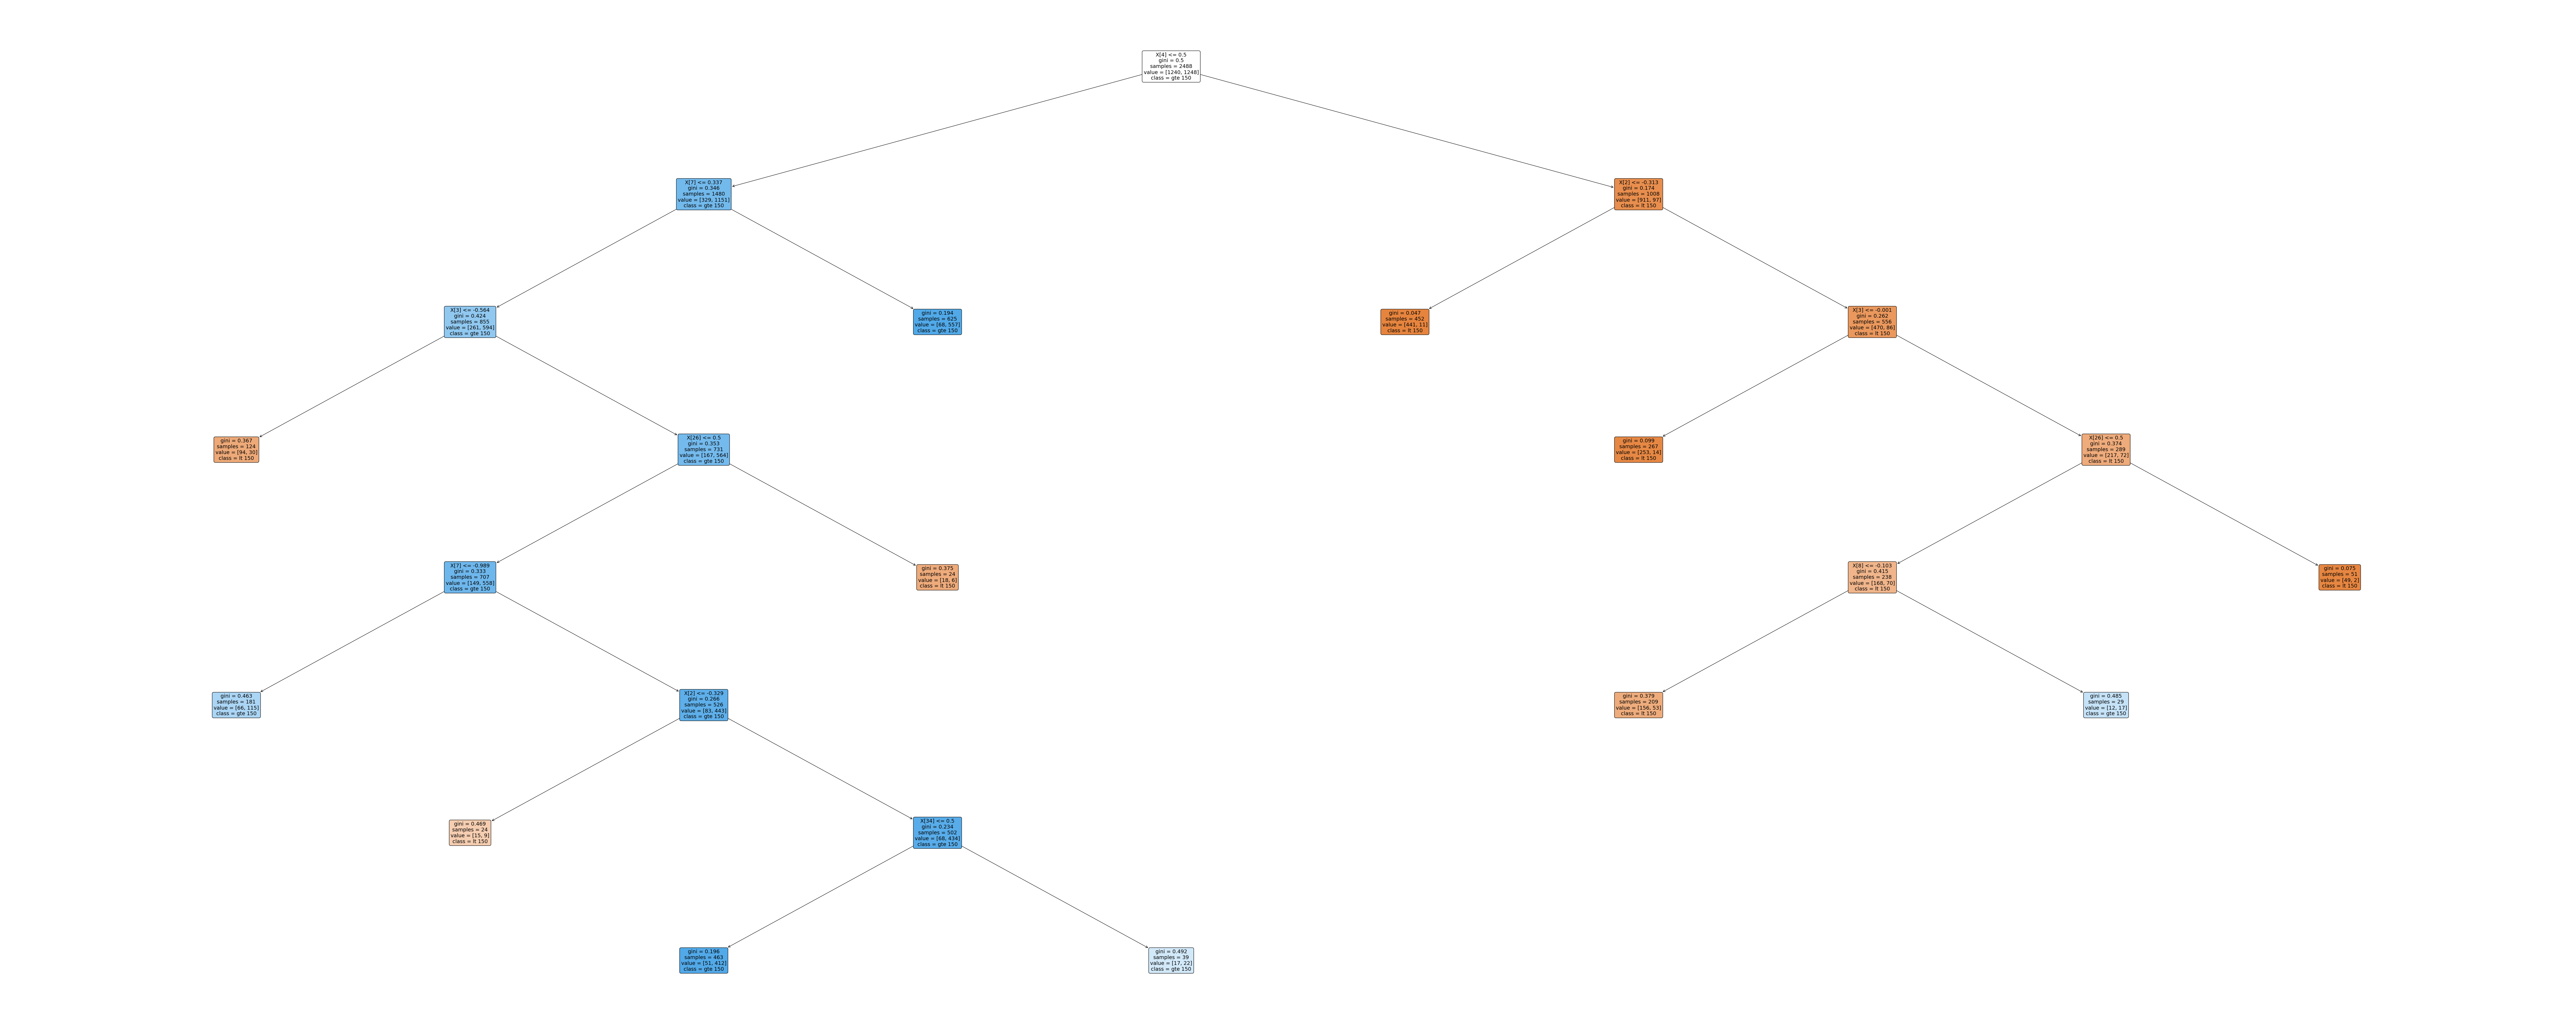

In [11]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(125,50))
tree = plot_tree(rand_search.best_estimator_, 
              #feature_names=train_inputs.columns.values, # our feature names are stripped from the data set
              class_names=['lt 150', 'gte 150'], 
              filled=True, 
              rounded=True, 
              fontsize=14)

## 5.0  Results

I applied the Decisition Tree classification model using Randomized search approach and SVM classification model using polynomial kernel with randomized search approach. 

Precision was used as the scoring measure to optimize. The parameters for the best precision score for **SVM model** comes out to be : *{'gamma': 'auto', 'degree': 3, 'coef0': 2, 'C': 9}* and the parameters for the best precision score for **Decision Tree** is : *{'min_samples_split': 37, 'min_samples_leaf': 19, 'min_impurity_decrease': 0.0021, 'max_leaf_nodes': 58, 'max_depth': 18, 'criterion': 'gini'}*.

As we can see from the confusion matrix, SVM poly model has a precision of 0.848 and Decision Tree model has a precision of 0.833. Thus in terms of precision, SVM poly performed better than the Decision Tree model.
